# Project Football

In this project we checked historical data about football matches.

_SOL_: I made a change about some business questions.

## Data Collection

In [121]:
import warnings
warnings.filterwarnings('ignore')

In [122]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# get data from kaggle
football_train_df = pd.read_csv('./data/football_train.csv')
football_target_df = pd.read_csv('./data/football_target.csv')

# print shapes
print("train shape:",football_train_df.shape)
print("target shape:",football_target_df.shape)


train shape: (110938, 190)
target shape: (110938, 3)


In [123]:
football_target_df.set_index('id', inplace=True)
football_train_df.set_index('id', inplace=True)

In [124]:
# join football_train_df and football_target_df (only score column)
football_target_df = football_target_df[['score']]
football_train_df = football_train_df.join(football_target_df)
print(football_train_df.shape)

(110938, 190)


## Data Preprocessing

### Data Cleaning

We remove, fill, replace, ...

In [125]:
# remove every team that has less than 10 matches
teams_less_10_matches = football_train_df['home_team_name'].value_counts() < 10
teams_less_10_matches = teams_less_10_matches[teams_less_10_matches].index

# remove teams from teams_less_10_matches
football_train_df = football_train_df[~football_train_df['home_team_name'].isin(teams_less_10_matches)]
football_train_df = football_train_df[~football_train_df['away_team_name'].isin(teams_less_10_matches)]
print(football_train_df.shape)

(79055, 190)


In [126]:
# Extract diccionary with the league_id and league_name and drop league_name from the dataframes
league_dict = football_train_df[['league_id', 'league_name']].drop_duplicates().set_index('league_id').to_dict()['league_name']
print(football_train_df.shape)


(79055, 190)


Se eliminaron los datos del coach debido a que habian muy poquitos que cumplian con esto y solamente añadia ruido \
Eliminamos todos los equipos que tuvieran menos de 10 partidos en el historico \
Eliminamos aquellas filas que tengan menos del 50% de información disponible


### Filtros opcionales (ejecutar sin eliminar los equipos)

In [127]:
# remove every column has "coach" in his name
football_train_df = football_train_df[football_train_df.columns.drop(list(football_train_df.filter(regex='coach', axis=1)))]
print(football_train_df.shape)

(79055, 168)


In [128]:
# remove every row has more than 50% of missing values
football_train_df = football_train_df.dropna(thresh=0.5*len(football_train_df), axis=1)
print(football_train_df.shape)


(79055, 168)


In [129]:
# remove every row has more than 70% of missing values
football_train_df = football_train_df.dropna(thresh=0.7*len(football_train_df.columns), axis=0)
print(football_train_df.shape)

(77551, 168)


In [130]:
# code to remove duplicates
football_train_df = football_train_df.drop_duplicates()

In [131]:
# imprimir columnas
football_train_df.columns.to_list()

['target',
 'home_team_name',
 'away_team_name',
 'match_date',
 'league_name',
 'league_id',
 'is_cup',
 'home_team_history_match_date_1',
 'home_team_history_match_date_2',
 'home_team_history_match_date_3',
 'home_team_history_match_date_4',
 'home_team_history_match_date_5',
 'home_team_history_match_date_6',
 'home_team_history_match_date_7',
 'home_team_history_match_date_8',
 'home_team_history_match_date_9',
 'home_team_history_match_date_10',
 'home_team_history_is_play_home_1',
 'home_team_history_is_play_home_2',
 'home_team_history_is_play_home_3',
 'home_team_history_is_play_home_4',
 'home_team_history_is_play_home_5',
 'home_team_history_is_play_home_6',
 'home_team_history_is_play_home_7',
 'home_team_history_is_play_home_8',
 'home_team_history_is_play_home_9',
 'home_team_history_is_play_home_10',
 'home_team_history_is_cup_1',
 'home_team_history_is_cup_2',
 'home_team_history_is_cup_3',
 'home_team_history_is_cup_4',
 'home_team_history_is_cup_5',
 'home_team_histor

### Data Preparation

In [132]:
from sklearn.preprocessing import LabelEncoder

# change datetime format
# filter date columns and change datatype
for col in football_train_df.filter(regex='date', axis=1).columns:
    football_train_df[col] = pd.to_datetime(football_train_df[col])

# Set league_name as category
football_train_df['league_name'] = football_train_df['league_name'].astype('category')

# Label encoding target
le = LabelEncoder()
football_train_df['target'] = le.fit_transform(football_train_df['target'])

# Label encoding is_coup
football_train_df['is_cup'] = le.fit_transform(football_train_df['is_cup'])

# Separate score column # - # in two columns home_score and away_score and merge it with football_train_df
football_train_df['home_score'] = football_train_df['score'].str.split('-', expand=True)[0].astype(int)
football_train_df['away_score'] = football_train_df['score'].str.split('-', expand=True)[1].astype(int)
football_train_df.drop('score', axis=1, inplace=True)



## Feature Engineering


In [133]:
# Feature Engineering
football_reduced_df = football_train_df[[
    'home_team_name',
    'away_team_name',
    'match_date',
    'league_name',
    'is_cup',
    'home_score',
    'away_score',
    'target']].copy()

# Calculate last home team match
# find the days between the last match of the home team
football_reduced_df['home_days_betwent_last_match'] = (football_reduced_df['match_date'] - football_train_df['home_team_history_match_date_1']).dt.days
football_reduced_df['home_days_betwent_last_match'].head(10)

# home average goals in last 10 matches (columns home_team_history_goal_1 to home_team_history_goal_10)
football_reduced_df['home_avg_home_goal_last_10'] = football_train_df.filter(regex='home_team_history_goal', axis=1).mean(axis=1)
football_reduced_df['home_avg_opponent_goal_last_10'] = football_train_df.filter(regex='home_team_history_opponent_goal', axis=1).mean(axis=1)

football_reduced_df['away_avg_home_goal_last_10'] = football_train_df.filter(regex='away_team_history_goal', axis=1).mean(axis=1)
football_reduced_df['away_avg_opponent_goal_last_10'] = football_train_df.filter(regex='away_team_history_opponent_goal', axis=1).mean(axis=1)
# Aqui podemos hacer feature engineering para obtener la cantidad de partidos jugados por cada equipo

# Habra algun mes en donde el rendimiento se vea aectado?
# create columns by month based on date
football_reduced_df['month'] = football_reduced_df['match_date'].dt.month

# how many matches did win the home/away team in the last 10 matches
home_history_goals = football_train_df.filter(regex='home_team_history_goal', axis=1).to_numpy()
home_history_oponent_goals = football_train_df.filter(regex='home_team_history_opponent_goal', axis=1).to_numpy()
football_reduced_df['home_wins_last_10'] = (home_history_goals > home_history_oponent_goals).sum(axis=1)
football_reduced_df['home_dawn_last_10'] = (home_history_goals == home_history_oponent_goals).sum(axis=1)
football_reduced_df['home_lose_last_10'] = (home_history_goals < home_history_oponent_goals).sum(axis=1)

away_history_goals = football_train_df.filter(regex='away_team_history_goal', axis=1).to_numpy()
away_history_oponent_goals = football_train_df.filter(regex='away_team_history_opponent_goal', axis=1).to_numpy()
football_reduced_df['away_wins_last_10'] = (away_history_goals > away_history_oponent_goals).sum(axis=1)
football_reduced_df['away_dawn_last_10'] = (away_history_goals == away_history_oponent_goals).sum(axis=1)
football_reduced_df['away_lose_last_10'] = (away_history_goals < away_history_oponent_goals).sum(axis=1)

# mean team rating and oponent rating
football_reduced_df['home_avg_rating_last_10'] = football_train_df.filter(regex='home_team_history_rating', axis=1).mean(axis=1)
football_reduced_df['home_avg_opponent_rating_last_10'] = football_train_df.filter(regex='home_team_history_opponent_rating', axis=1).mean(axis=1)

football_reduced_df['away_avg_rating_last_10'] = football_train_df.filter(regex='away_team_history_rating', axis=1).mean(axis=1)
football_reduced_df['away_avg_opponent_rating_last_10'] = football_train_df.filter(regex='away_team_history_opponent_rating', axis=1).mean(axis=1)

print(football_reduced_df.shape)


(77530, 24)


In [134]:
football_reduced_df.columns

Index(['home_team_name', 'away_team_name', 'match_date', 'league_name',
       'is_cup', 'home_score', 'away_score', 'target',
       'home_days_betwent_last_match', 'home_avg_home_goal_last_10',
       'home_avg_opponent_goal_last_10', 'away_avg_home_goal_last_10',
       'away_avg_opponent_goal_last_10', 'month', 'home_wins_last_10',
       'home_dawn_last_10', 'home_lose_last_10', 'away_wins_last_10',
       'away_dawn_last_10', 'away_lose_last_10', 'home_avg_rating_last_10',
       'home_avg_opponent_rating_last_10', 'away_avg_rating_last_10',
       'away_avg_opponent_rating_last_10'],
      dtype='object')

## Model Selection

In [135]:
# get columns datatype
football_reduced_df.dtypes

# join football_reduced_df and football_train_df
football_train_df = football_train_df.join(football_reduced_df[[
       'home_days_betwent_last_match', 'home_avg_home_goal_last_10',
       'home_avg_opponent_goal_last_10', 'away_avg_home_goal_last_10',
       'away_avg_opponent_goal_last_10', 'month', 'home_wins_last_10',
       'home_dawn_last_10', 'home_lose_last_10', 'away_wins_last_10',
       'away_dawn_last_10', 'away_lose_last_10', 'home_avg_rating_last_10',
       'home_avg_opponent_rating_last_10', 'away_avg_rating_last_10',
       'away_avg_opponent_rating_last_10']])


In [136]:

print(football_train_df.shape)
#football_reduced_df.dropna(inplace=True)
print(football_reduced_df.shape)

(77530, 185)
(77530, 24)


In [137]:
# Split into test dataset and train dataset
from sklearn.model_selection import train_test_split

# Suponiendo que tienes un DataFrame football_reduced_df con las características
X = football_reduced_df.drop([
    'home_team_name',
    'away_team_name',
    'target',
    'match_date',
    'league_name',
    'home_score',
    'away_score'], axis=1)

Y = football_reduced_df['target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



### Test Linear Regression


### Test K-Nearest Neighbors

In [138]:
# Test KKN for classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, Y_train)

y_hat = knn.predict(X_test)
knn_accuracy=accuracy_score(Y_test, y_hat)
print("knn accuracy: ",knn_accuracy)

knn accuracy:  0.4430543015606862


### Random Forest

In [139]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

y_hat = rf.predict(X_test)
rf_accuracy=accuracy_score(Y_test, y_hat)
print("rf accuracy: ",rf_accuracy)



rf accuracy:  0.4678189088094931


In [140]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#scores = cross_val_score(rf, X, Y, cv=5, scoring='accuracy')
#print(scores)
# Random forest with original dropped data
#aux_df = football_train_df.dropna().copy()
se = StandardScaler()

aux_df = football_train_df.copy()
for col in aux_df.filter(regex='date', axis=1).columns:
    aux_df.drop(col, axis=1, inplace=True)

X = aux_df.drop([
    'home_team_name',
    'away_team_name',
    #'target',
    'league_name',
    'home_score',
    'away_score'], axis=1)

X = X.fillna(0)
Y = X['target']
X.drop('target', axis=1, inplace=True)

X = se.fit_transform(X)
Y = le.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(X_train.shape)



(69777, 158)


In [143]:
from sklearn.ensemble import RandomForestClassifier
rf_scaled = RandomForestClassifier(n_estimators=200)
rf_scaled.fit(X_train, Y_train)
rf_Y_test=Y_test.copy()
rf_x_train=X_train.copy()
rf_y_train=Y_train.copy()
rf_x_test=X_test.copy()
rf_y_hat = rf_scaled.predict(X_test)
rf_scaled_accuracy=accuracy_score(Y_test, rf_y_hat)
print("rf scaled accuracy: ",rf_scaled_accuracy)




rf scaled accuracy:  0.4840706823165226


In [142]:
# Cross validation Random FOrest
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, Y, cv=5, scoring='accuracy')
print(scores)

KeyboardInterrupt: 

In [ ]:
print(type(scores))

<class 'numpy.ndarray'>


In [ ]:
scores = cross_val_score(rf, X, Y, cv=5, scoring='accuracy')
print(scores)

|     | reducced | full_dropna_without_coach |fd_fill0_without_coach | Merged |
|-----|----------|---------------------------|-----------------------|--------|
| kn  | 0.44     |      0.39                 |          0.42         |        |
| rt  | 0.46     |      0.47                 |          0.46         |        |
|CV-kn|          |                           |          0.41         |        |
|CV-rt|          |                           |       0.99 - 1        |        |

In [ ]:
print(X.shape)

(74641, 143)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, Y_train)
y_hat = knn.predict(X_test)
knn_scaled_accuracy=accuracy_score(Y_test, y_hat)
print("knn scaled accuracy: ",knn_scaled_accuracy)

knn scaled accuracy:  0.47388107829227394


In [ ]:
# knn cross validation
scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
print(scores)

[0.40980642 0.40159432 0.40507771 0.42825563 0.4249732 ]


In [ ]:
scores.mean()

0.4139414548979496

### Test XGBoost for Regression

In [ ]:
# code for a XGBoost regressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb = XGBClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 500],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}

random_search = RandomizedSearchCV(xgb, param_grid, n_iter=20, scoring='accuracy', cv=2, verbose=1, n_jobs=-1)
random_search.fit(X_train, Y_train)

print(f"Best parameters found by Grid Search: {random_search.best_params_}")
#y_hat = xgb.predict(X_test)
#accuracy_score(Y_test, y_hat)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
from xgboost import XGBClassifier

params = {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.5}
xgb = XGBClassifier(params)
xgb.fit(X_train, Y_train)

y_hat = xgb.predict(X_test)
xgb_scaled_accuracy=accuracy_score(Y_test, y_hat)
print("xgb scaled accuracy: ",xgb_scaled_accuracy)

xgb scaled accuracy:  0.47891138913968784


Un modelo aleatorio es mejor?

In [ ]:
# generate pandas df with random integer values 0, 1 or 2
import numpy as np
df = pd.DataFrame(np.random.randint(0, 3, size=football_target_df.shape), columns=['random'])
print(football_train_df.shape)

# Count random column and target column and calculate accuracy
accuracy_score(df['random'], football_train_df['target'])


(77530, 185)


ValueError: Found input variables with inconsistent numbers of samples: [110938, 77530]

In [ ]:
# Red neuronal con Tenserflow
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# One hot encoding in Y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)

ann = Sequential()
ann.add(Dense(units=8, activation='tanh', input_dim=X_train.shape[1]))
ann.add(Dense(units=8, activation='softmax'))
ann.add(Dense(units=8, activation='relu'))
ann.add(Dense(units=8, activation='softmax'))
ann.add(Dense(units=8, activation='relu'))
ann.add(Dense(units=8, activation='relu'))
ann.add(Dense(units=8, activation='tanh'))
ann.add(Dense(units=3, activation='relu'))

ann.compile( optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'] )

ann.fit(X_train, Y_train, epochs=20, batch_size=32)


(69777, 158)
(69777, 3)
Epoch 1/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3101 - loss: nan
Epoch 2/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3133 - loss: nan
Epoch 3/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3114 - loss: nan
Epoch 4/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3080 - loss: nan
Epoch 5/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3115 - loss: nan
Epoch 6/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3130 - loss: nan
Epoch 7/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3110 - loss: nan
Epoch 8/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3117 - loss: nan
Epoch 9/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3107 - loss: nan
Epoch 10/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3117 - loss: nan
Epoch 11/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3134 - loss: nan
Epoch 12/20
2181/2181 ━━━━━━━━━━━

In [ ]:
loss, ann_accuracy = ann.evaluate(X_test, Y_test)
print("Accuracy:", ann_accuracy)

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3203 - loss: nan
Accuracy: 0.3125241696834564


### Models Comparison

_Accuracy comparation_

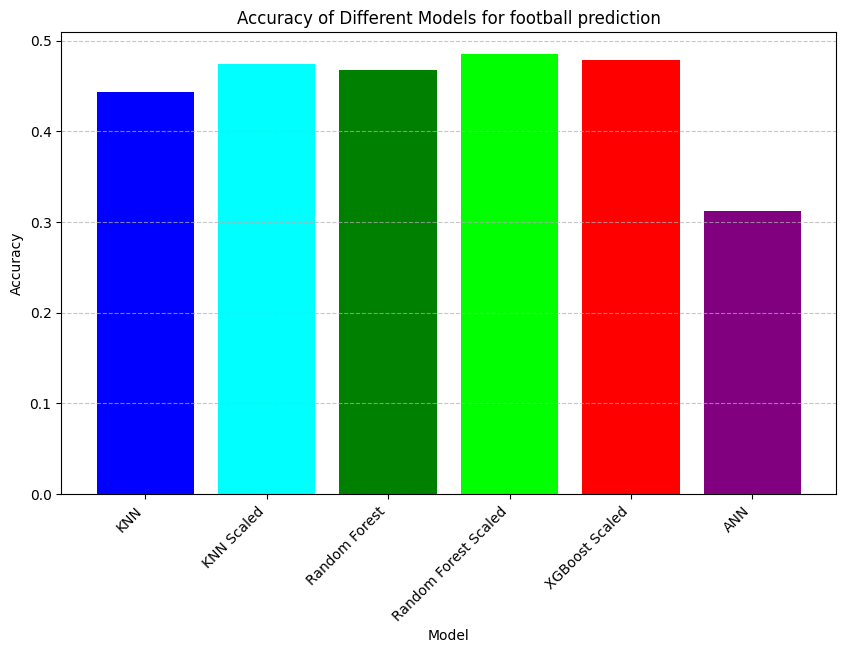

In [ ]:
import matplotlib.pyplot as plt
# Nombres de los modelos
models = ['KNN', 'KNN Scaled', 'Random Forest', 'Random Forest Scaled', 'XGBoost Scaled', 'ANN']

# Precisión de los modelos
accuracies = [knn_accuracy, knn_scaled_accuracy, rf_accuracy, rf_scaled_accuracy, xgb_scaled_accuracy, ann_accuracy]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'cyan', 'green', 'lime', 'red', 'purple'])

# Añadir título y etiquetas
plt.title('Accuracy of Different Models for football prediction')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Rotar etiquetas del eje x
plt.xticks(rotation=45, ha='right')

# Añadir cuadrícula
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.show()



## Model Training

In [ ]:
# prepare data for the model

# scaling data - additional encoder

# feature selection

# create model with hyperparameters

# train model

## Model Evaluation

_Tomando random forest escalado como el mejor modelo propuesto_

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(rf_Y_test, rf_y_hat)
precision = precision_score(rf_Y_test, rf_y_hat, average='weighted')
recall = recall_score(rf_Y_test, rf_y_hat, average='weighted')
f1 = f1_score(rf_Y_test, rf_y_hat, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.48574745259899393
Precision: 0.4419723052164797
Recall: 0.48574745259899393
F1 Score: 0.4208902617332983


_Gráfica de Barras accuracy_score, precision_score, recall_score, f1_score_

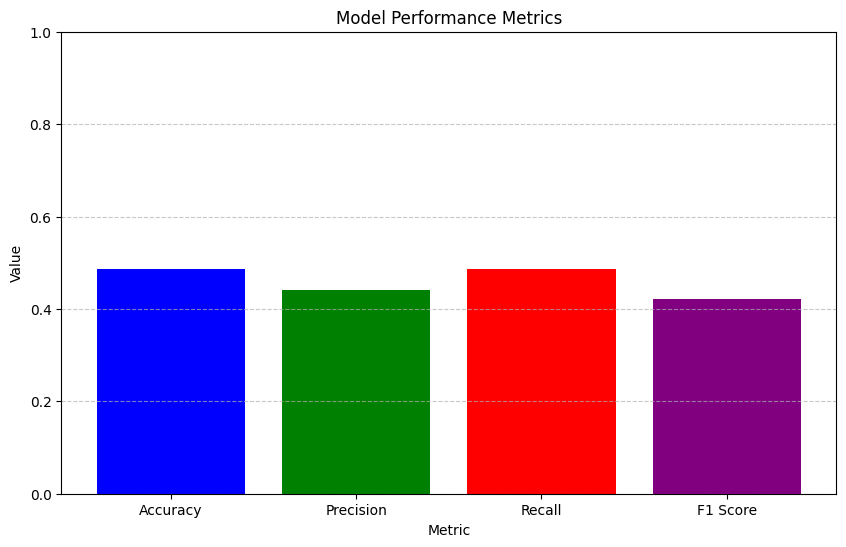

In [ ]:
import matplotlib.pyplot as plt

# Datos de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Añadir título y etiquetas
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.ylim([0, 1])  # Asumiendo que los valores están en el rango de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.show()


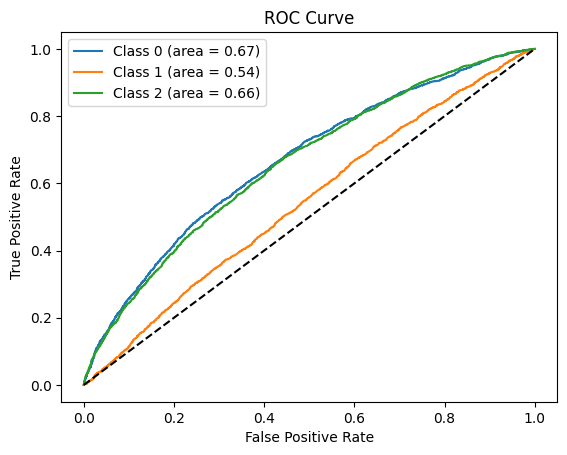

In [144]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarizar las etiquetas para ROC multi-clase
Y_test_bin = label_binarize(rf_Y_test, classes=[0, 1, 2])  # Ajustar según tus clases
n_classes = Y_test_bin.shape[1]

# Predecir las probabilidades
rf_classifier = OneVsRestClassifier(rf_scaled)
y_score = rf_classifier.fit(rf_x_train, rf_y_train).predict_proba(rf_x_test)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crear la gráfica de la curva ROC para cada clase
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

# Añadir la línea de suerte (0.5)
plt.plot([0, 1], [0, 1], 'k--')

# Añadir título y etiquetas
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

# Mostrar la gráfica
plt.show()


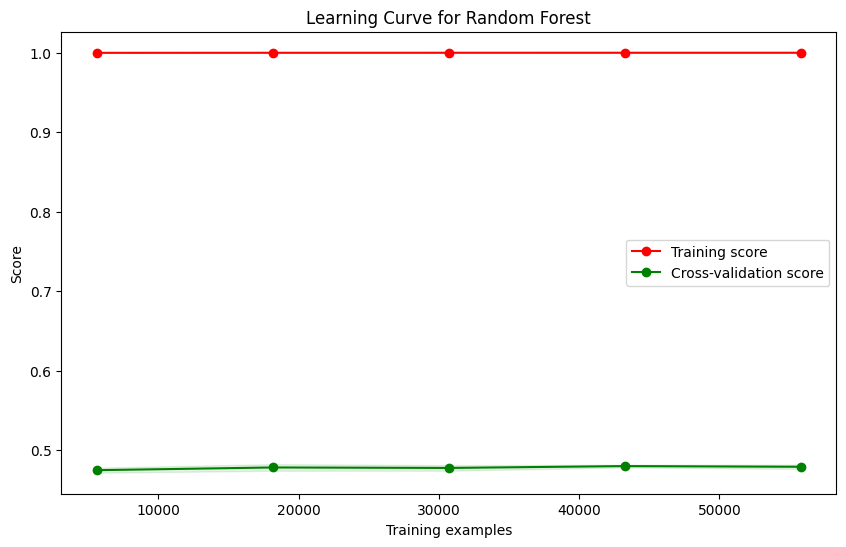

In [146]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(rf_scaled, rf_x_train, rf_y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Crear la gráfica de la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Añadir título y etiquetas
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')

# Mostrar la gráfica
plt.show()


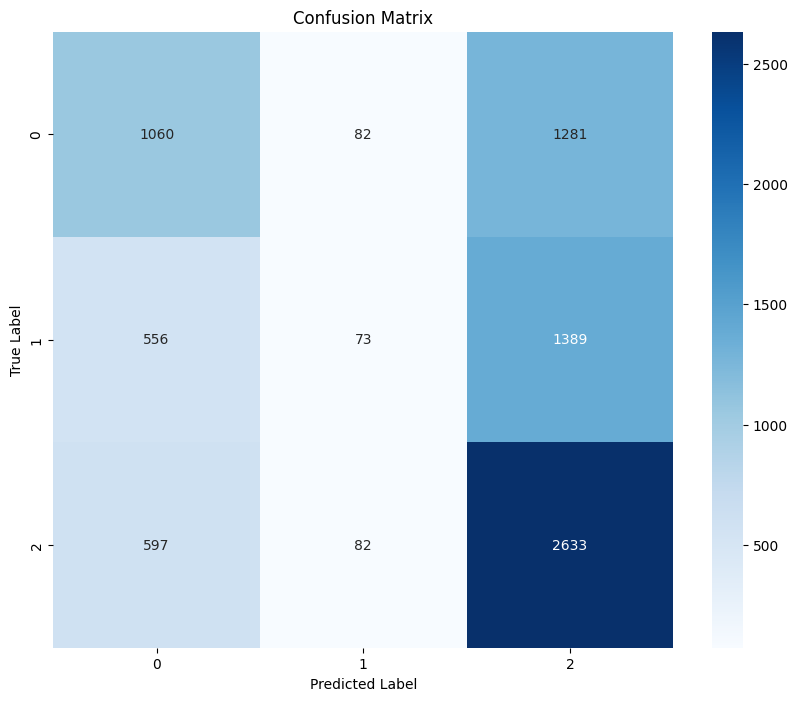

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(rf_Y_test, rf_y_hat)

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Añadir título y etiquetas
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Mostrar la gráfica
plt.show()


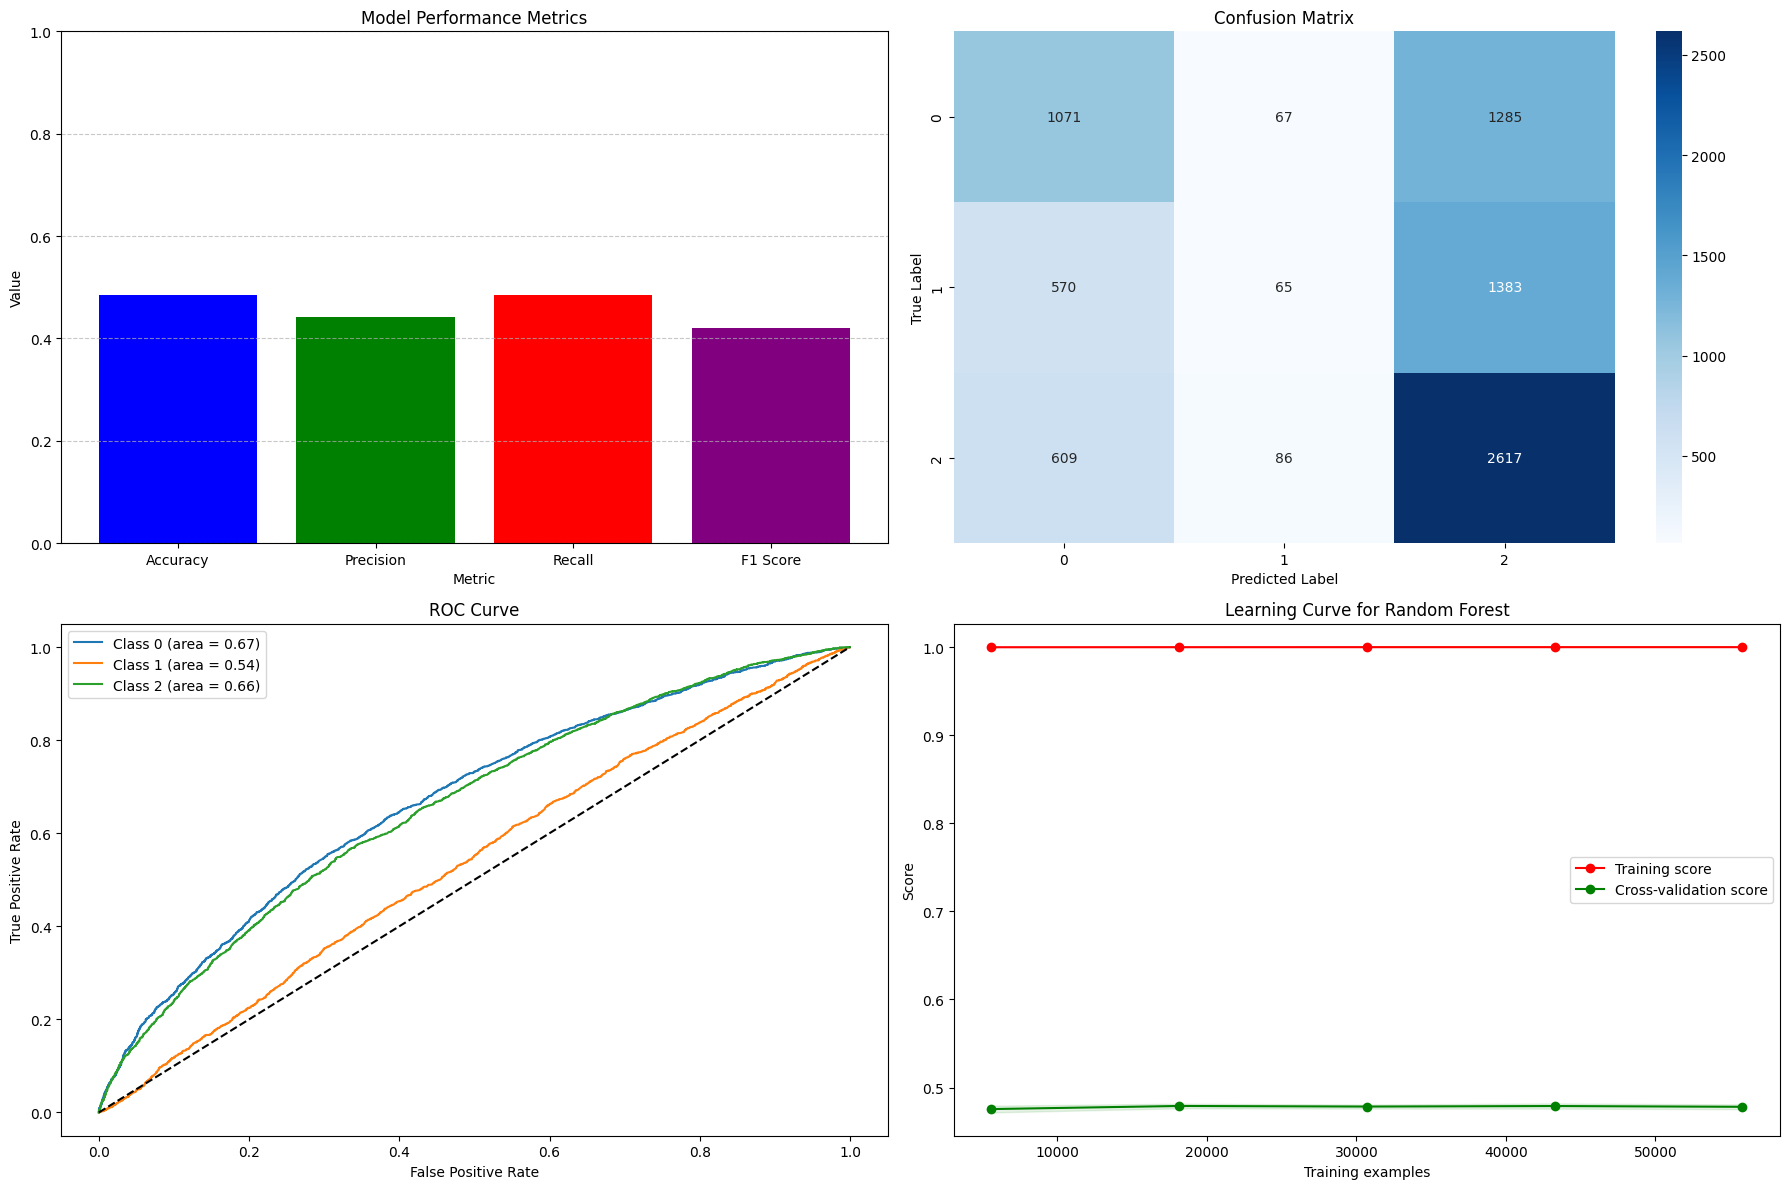

Gráfica guardada en: graficas_resultantes\combined_plot.png


In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve
import numpy as np
import os

# Crear una carpeta para guardar las imágenes si no existe
output_dir = 'graficas_resultantes'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Datos de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Crear la figura con subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Gráfica 1: Métricas de rendimiento
bars = ax1.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
ax1.set_title('Model Performance Metrics')
ax1.set_xlabel('Metric')
ax1.set_ylabel('Value')
ax1.set_ylim([0, 1])  # Asumiendo que los valores están en el rango de 0 a 1
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfica 2: Matriz de confusión
conf_matrix = confusion_matrix(rf_Y_test, rf_y_hat)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# Gráfica 3: Curva ROC
# Binarizar las etiquetas para ROC multi-clase
Y_test_bin = label_binarize(rf_Y_test, classes=[0, 1, 2])  # Ajustar según tus clases
n_classes = Y_test_bin.shape[1]

# Predecir las probabilidades
rf_classifier = OneVsRestClassifier(rf_scaled)
y_score = rf_classifier.fit(rf_x_train, rf_y_train).predict_proba(rf_x_test)

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase en ax3
for i in range(n_classes):
    ax3.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

# Añadir la línea de suerte (0.5)
ax3.plot([0, 1], [0, 1], 'k--')
ax3.set_title('ROC Curve')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.legend(loc='best')

# Gráfica 4: Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(rf_scaled, rf_x_train, rf_y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Crear la gráfica de la curva de aprendizaje en ax4
ax4.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
ax4.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='g', alpha=0.1)
ax4.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
ax4.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Añadir título y etiquetas
ax4.set_title('Learning Curve for Random Forest')
ax4.set_xlabel('Training examples')
ax4.set_ylabel('Score')
ax4.legend(loc='best')

# Ajustar diseño
plt.tight_layout()

# Guardar la figura en la carpeta especificada
output_path = os.path.join(output_dir, 'combined_plot.png')
plt.savefig(output_path)

# Mostrar la figura
plt.show()

print(f"Gráfica guardada en: {output_path}")


In [ ]:
# pickle the model
import pickle

# save the model to disk
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

***

# Business Questions

1. What is the risk level for unpayments based on age and region?


In [ ]:
# generate a table or a plot or a business metric

2. What is average amount of unpayments? what is the segment of values where unpayments are appearin?

In [ ]:
# generate a table or a plot or a business metric